In [2]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import driver_opt_out, S_driver_opt_out, traveller_opt_out, S_traveller_opt_out
from MaaSSim.day_to_day import traveller_opt_out
from MaaSSim.day_to_day import d2d_kpi_veh
from MaaSSim.day_to_day import d2d_kpi_pax

Using TensorFlow backend.


In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [40]:
# the setting for TRB results do not delete
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 2000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.ini_att = 0.01 #0.5
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.platforms.comm_rate = float(0.10)
params.platforms.discount = float(0.0) # float(0.0)
params.platforms.daily_marketing = False

params.d2d.learning_d = 2 # 1 for TRB 
params.d2d.B_Experience = 0.80
params.d2d.B_WOM = 0.2
params.d2d.B_Marketing = 0.0
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 7 # 5 for TRB
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 1000 # 2000
params.nV = 100  # 200
params.nD = 800
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [ ]:
# sim = MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)




# sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)





# sim = MaaSSim.simulators.simulate(params=params,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)


sim = MaaSSim.simulators.simulate_rldqn_3act(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING,file_res='../../rl_results/rl_revs_single_tune4_0.02_0011_1000100.csv',stp=0.05,initial_comm_rate=0.2)



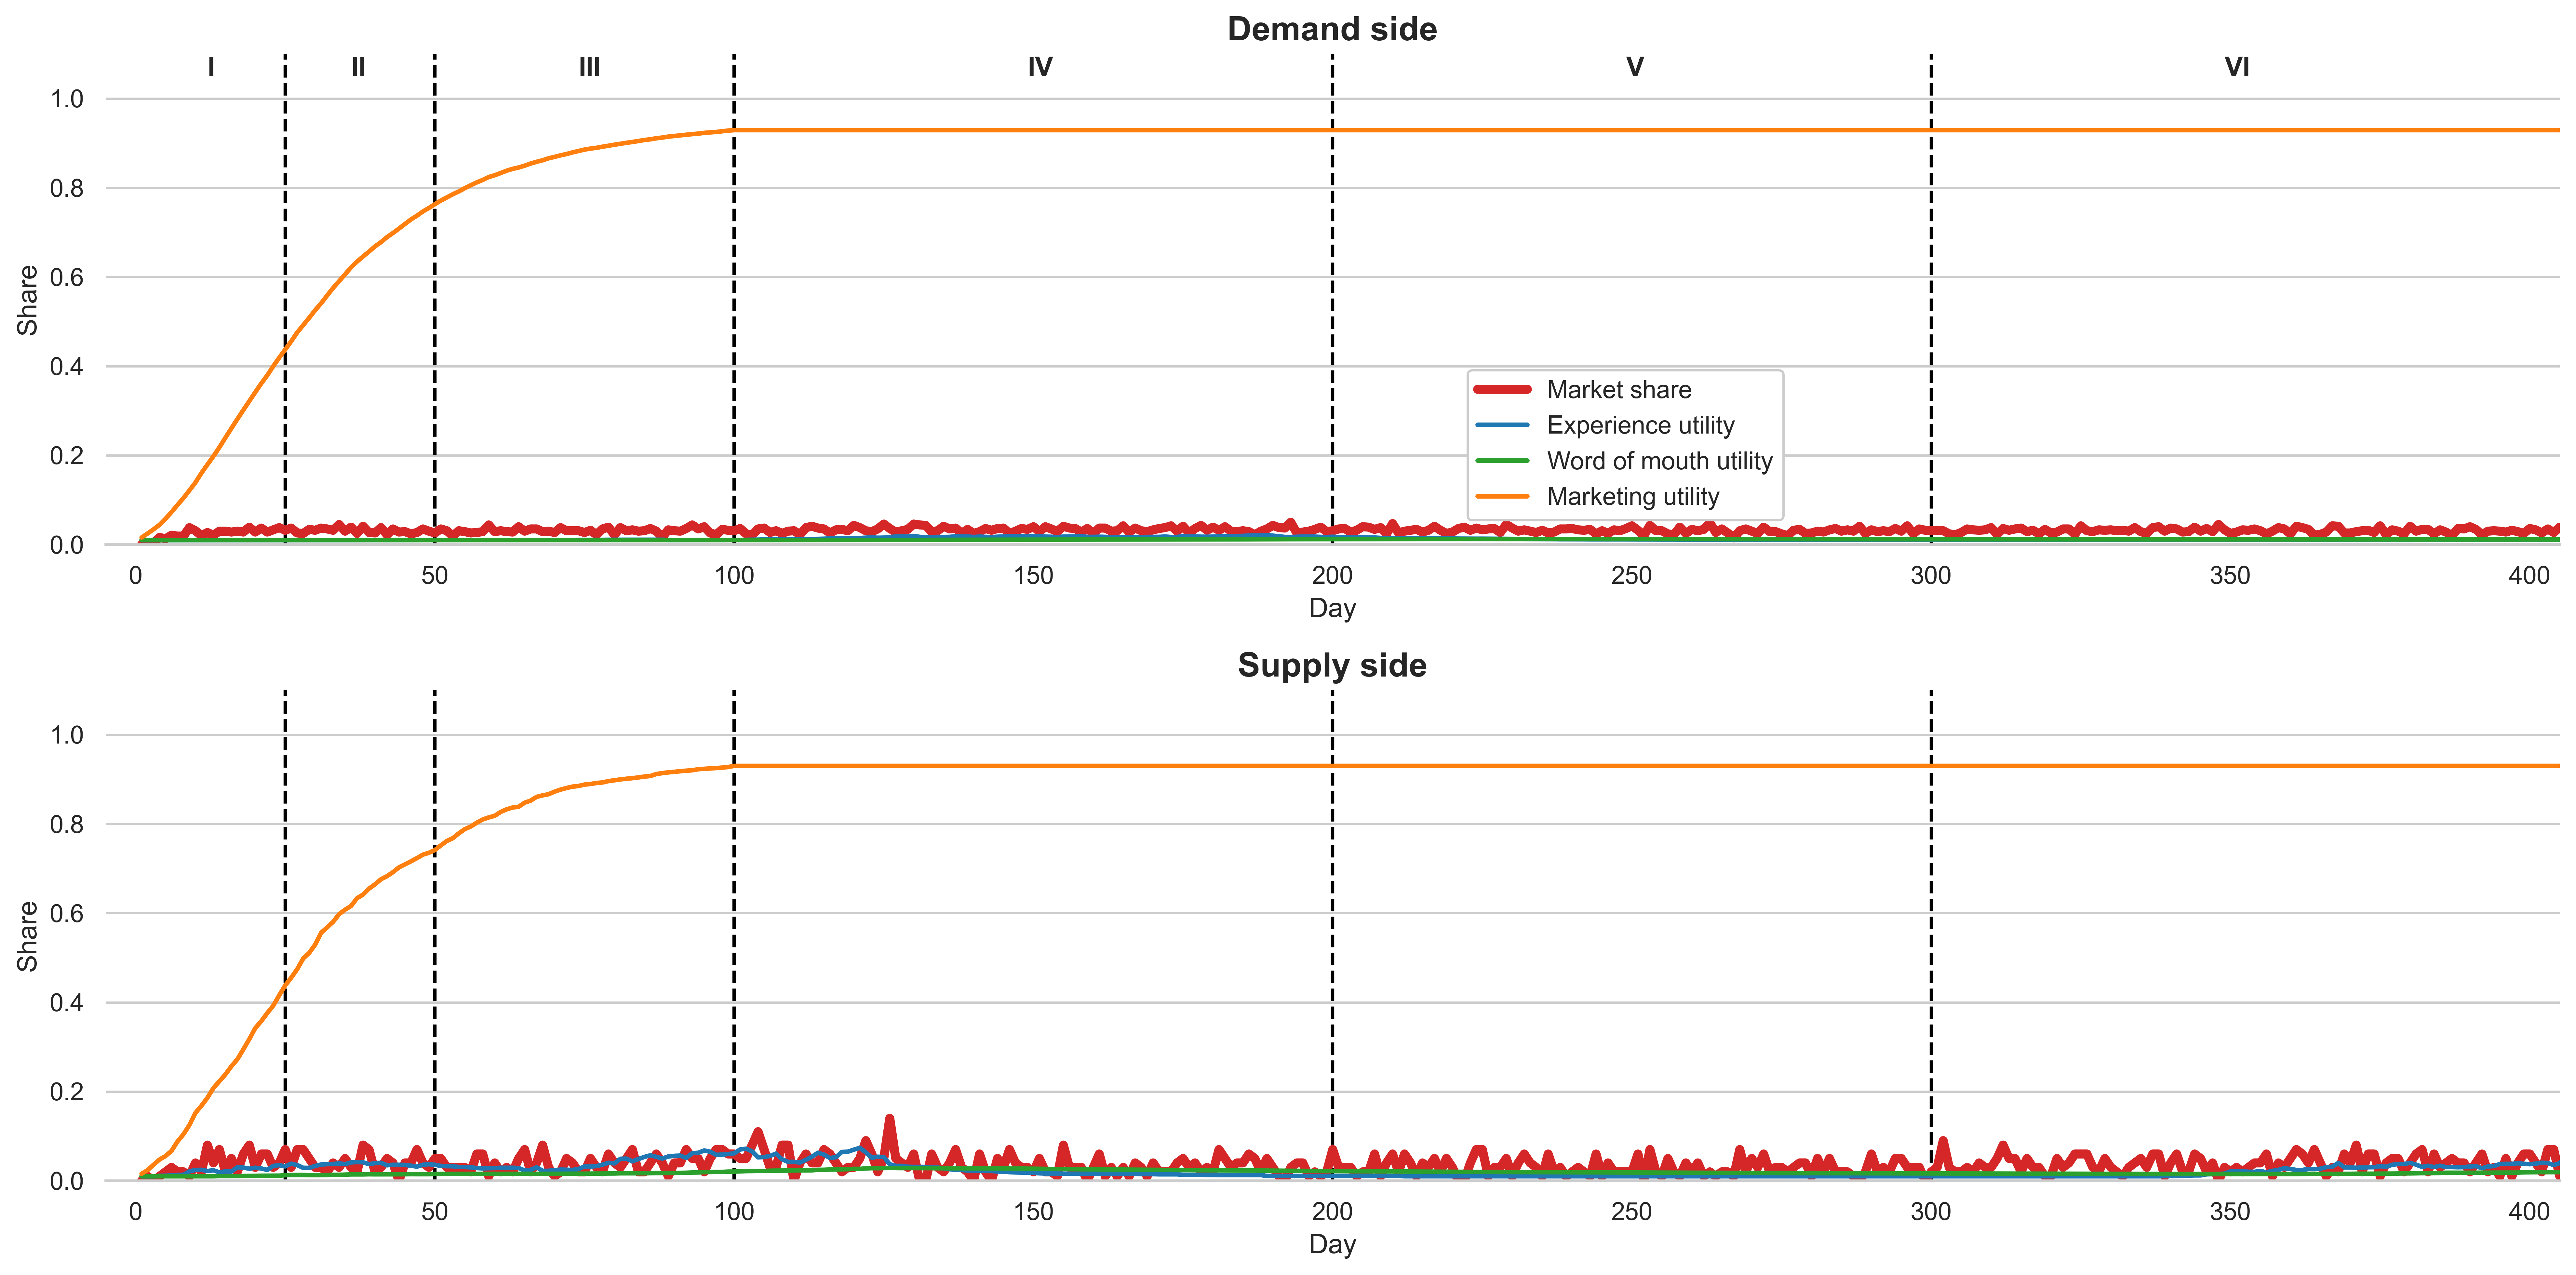

In [46]:
# nV=100, nP=1000, params.d2d.m = 7, and params.d2d.learning_d = 5
# marketing = 1-100, disc= 100-200, coms_0.5=300-400 

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.05))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

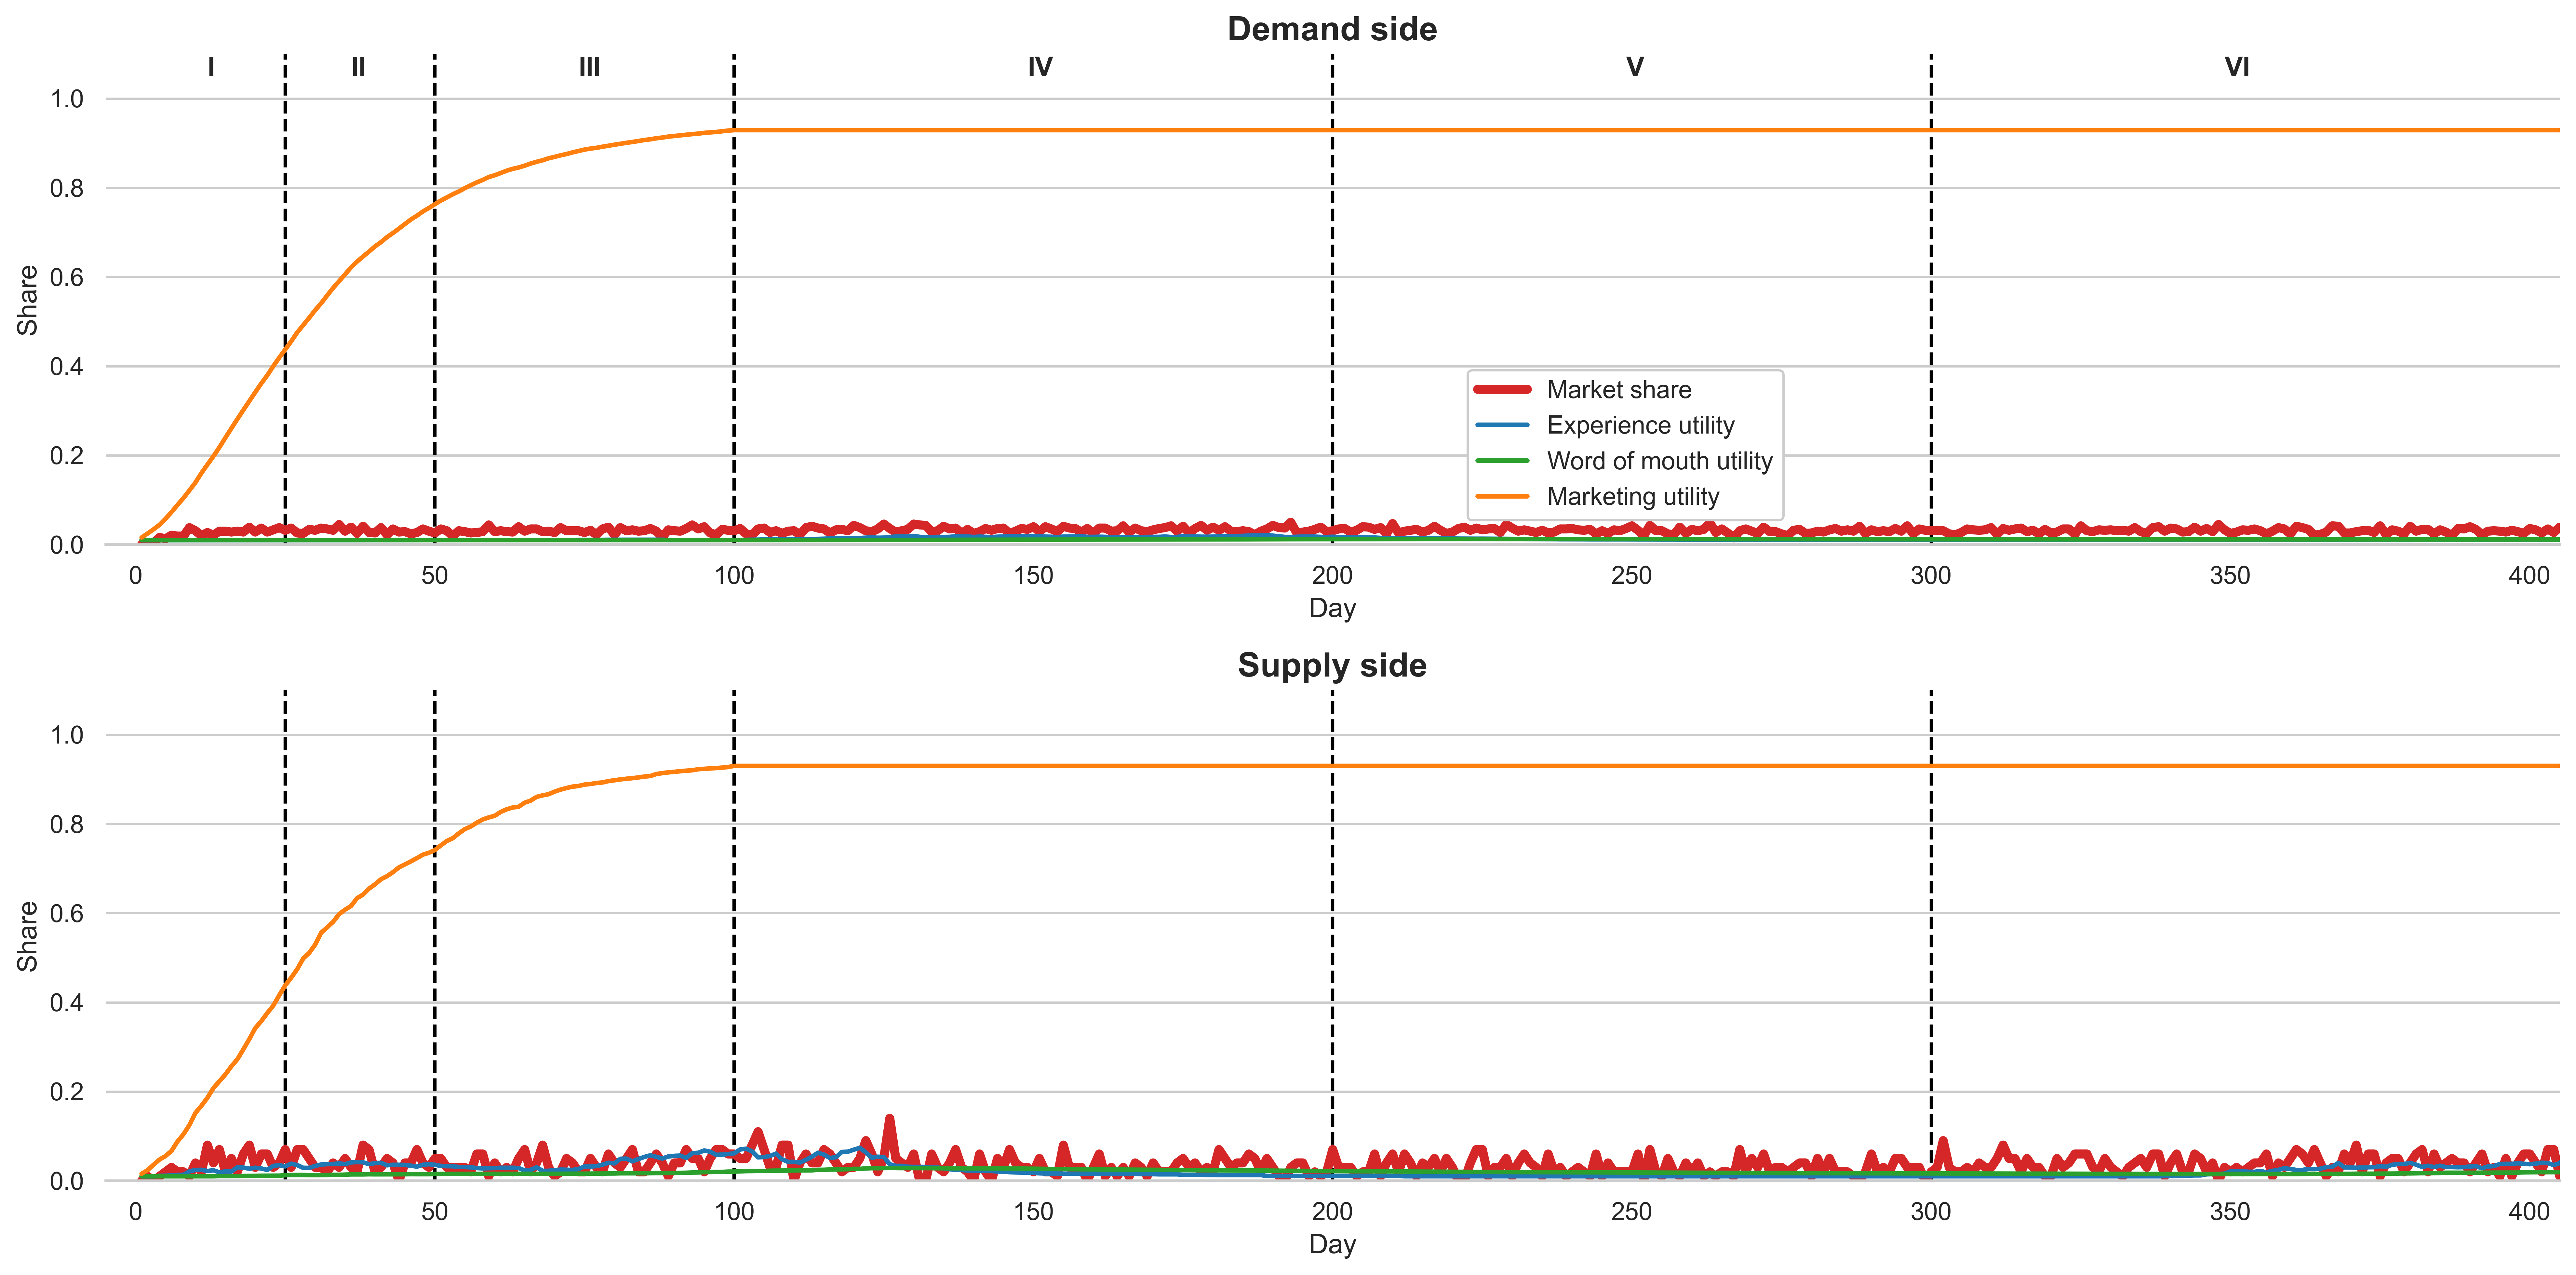

In [49]:
# nV=100, nP=1000, params.d2d.m = 7, and params.d2d.learning_d = 2
# marketing = 1-100, disc= 100-200, coms_0.5=300-400 

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.05))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

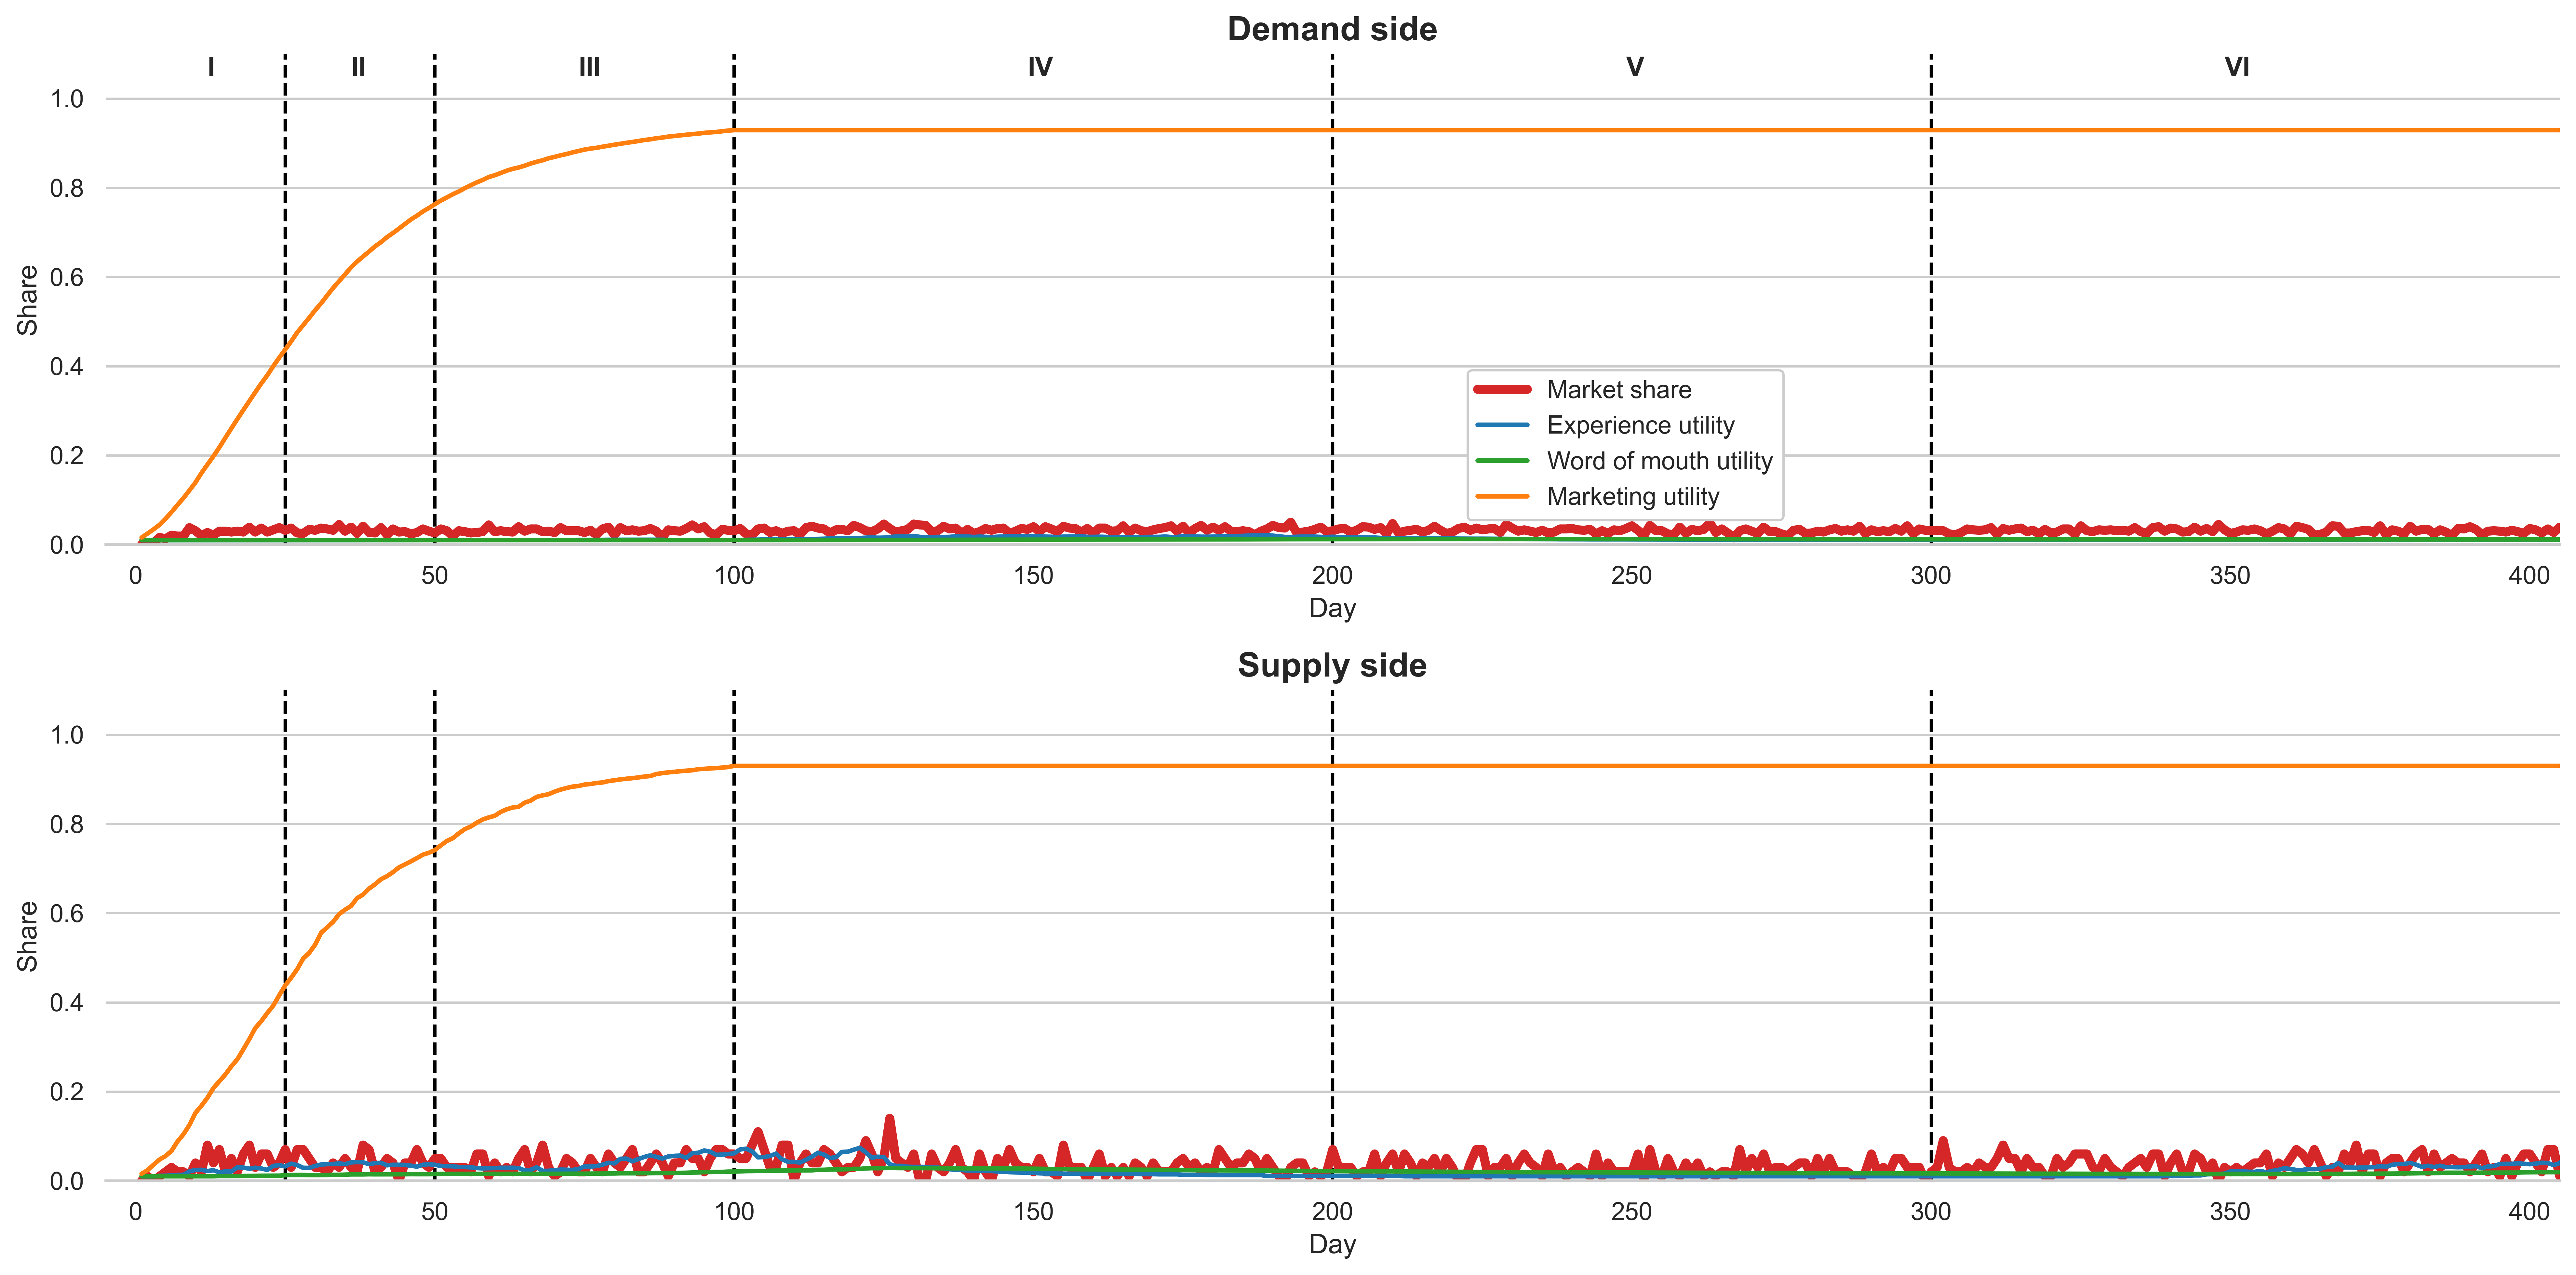

In [50]:
# nV=200, nP=2000, params.d2d.m = 7, and params.d2d.learning_d = 2
# marketing = 1-100, disc= 100-200, coms_0.5=300-400 

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,8))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)

for ax_n in [0,1]:
    
    x = []; ye = []; ym = []; yw = []; yms = []
    if ax_n==0:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].pax_exp.WOM_U.mean())
            ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
            ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
            
    if ax_n==1:
        for d in range(0,sim.params.nD):
            yw.append(sim.res[d].veh_exp.WOM_U.mean())
            ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
            ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
            yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
    
    lx = [i for i in range(1,len(ye)+1)]
    sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
    sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
   
    ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
    ax[ax_n].grid(axis='x')
    ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
    
ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.05))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[1].get_legend().set_visible(False)
for i in range(0,6):
    value = ['I','II','III','IV','V','VI']
    coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
    ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()
# plt.savefig('Fig1.png')

AttributeError: 'DataFrame' object has no attribute 'plat_profit'

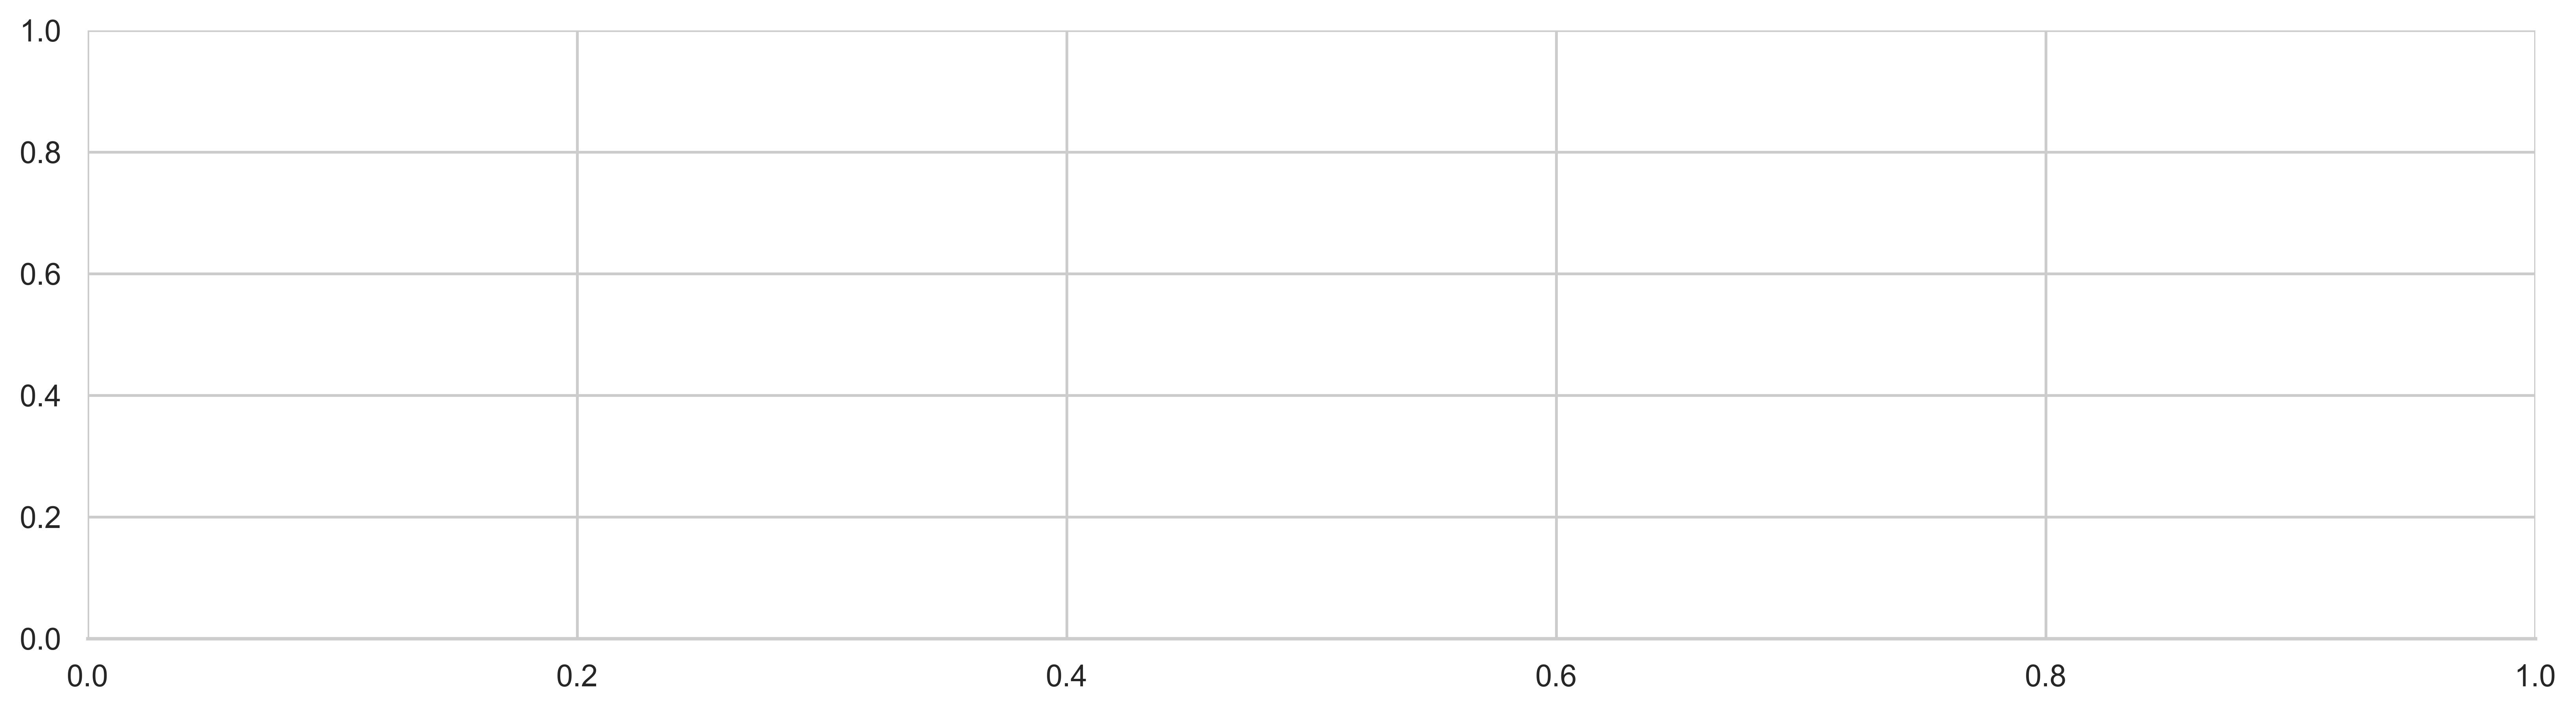

In [51]:
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(16,4))
sns.despine(left=True)

x = []
ypr = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    ypr.append(df[df.OUT==False].plat_profit.sum())
x = [i for i in range(1,len(ypr)+1)]

df = pd.Series(ypr).to_frame()
df.columns = ['income']
marketing_costs = 0.5
df['marketing costs']=df.apply(lambda x: -marketing_costs*2200 if x.name >50 and x.name<=100 else 0, axis = 1).astype(int)
df['profit']=df.income + df['marketing costs']

sns.lineplot(x=x, y=df.income.cumsum(), lw=3, label = 'Cumulative revenue', color='C0')#, marker='o')
sns.lineplot(x=x, y=df.profit.cumsum(), lw=3, label = 'Cumulative profit', color='C8')#, marker='o')
sns.lineplot(x=x, y=df['marketing costs'].astype(int).cumsum(), lw=3, label = 'Cumulative cost', color='C1')#, marker='o')

ax.grid(axis='x')
ax.vlines([25, 50, 100, 200, 300], -100000, 325000, linestyles='dashed', colors='black')
# sns.lineplot(x=x, y=ypr, label = 'plat_profit')#, marker='o')
sns.despine(left=True)
ax.set(xlim=(-5,410), ylim=(-100000,325000))
ax.legend(framealpha=1, loc=(0.55,0.72))

value = ['I','II','III','IV','V','VI']
for i in range(0,6):
    coords = [(12,312500),(36,312500),(74,312500),(149,312500),(249,312500),(349,312500)]
    ax.annotate(value[i], xy =coords[i], fontweight='bold')

plt.tight_layout()
# plt.savefig('Fig5.png')

In [5]:
# the setting for TRB results do not delete
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 2000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.ini_att = 0.01 #0.5
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.platforms.comm_rate = float(0.10)
params.platforms.discount = float(0.0) # float(0.0)
params.platforms.daily_marketing = False

params.d2d.learning_d = 2 # 1 for TRB
params.d2d.B_Experience = 0.80
params.d2d.B_WOM = 0.2
params.d2d.B_Marketing = 0.0
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 7 # 5 for TRB
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.nP = 1000 # 2000
params.nV = 100  # 200
params.nD = 800
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [ ]:
sim = MaaSSim.simulators.simulate_baseline(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING,file_res='../../rl_results/baseline_1000100.csv',stp=0.05,initial_comm_rate=0.2)

This simulation uses albatros data


[2023-02-10 14:39:33,260] Setting up 4h simulation at 2023-02-10 12:39:06 for 100 vehicles and 1000 passengers in Amsterdam, Netherlands


Day =  0
----------------> day: 0 of 800 <--------------------


[2023-02-10 14:39:37,698] simulation time 1.7 s


day:  0  nP:  0   nV:  0  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  0.0  new nV:  0  new nP:  0
Day =  1
----------------> day: 1 of 800 <--------------------


[2023-02-10 14:39:43,021] simulation time 1.8 s


day:  1  nP:  0   nV:  0  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  1.16  new nV:  2  new nP:  0
Day =  2
----------------> day: 2 of 800 <--------------------


[2023-02-10 14:39:48,355] simulation time 1.8 s


day:  2  nP:  2   nV:  0  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  5.72  new nV:  8  new nP:  0
Day =  3
----------------> day: 3 of 800 <--------------------


[2023-02-10 14:39:53,696] simulation time 1.9 s


day:  3  nP:  8   nV:  0  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  9.27  new nV:  12  new nP:  0
Day =  4
----------------> day: 4 of 800 <--------------------


[2023-02-10 14:39:59,309] simulation time 2.2 s


day:  4  nP:  12   nV:  0  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  9.08  new nV:  14  new nP:  2
Day =  5
----------------> day: 5 of 800 <--------------------


[2023-02-10 14:40:04,799] simulation time 1.9 s


day:  5  nP:  14   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  13.1  new nV:  19  new nP:  0
Day =  6
----------------> day: 6 of 800 <--------------------


[2023-02-10 14:40:10,547] simulation time 2.2 s


day:  6  nP:  19   nV:  0  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  14.72  new nV:  22  new nP:  1
Day =  7
----------------> day: 7 of 800 <--------------------


[2023-02-10 14:40:16,282] simulation time 2.2 s


day:  7  nP:  22   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  23.3  new nV:  30  new nP:  1
Day =  8
----------------> day: 8 of 800 <--------------------


[2023-02-10 14:40:22,207] simulation time 2.4 s


day:  8  nP:  30   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  21.35  new nV:  29  new nP:  2
Day =  9
----------------> day: 9 of 800 <--------------------


[2023-02-10 14:40:27,636] simulation time 2.1 s


day:  9  nP:  29   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  18.45  new nV:  20  new nP:  1
Day =  10
----------------> day: 10 of 800 <--------------------


[2023-02-10 14:40:33,574] simulation time 2.4 s


day:  10  nP:  20   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  20.43  new nV:  26  new nP:  4
Day =  11
----------------> day: 11 of 800 <--------------------


[2023-02-10 14:40:39,623] simulation time 2.6 s


day:  11  nP:  26   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  23.44  new nV:  33  new nP:  4
Day =  12
----------------> day: 12 of 800 <--------------------


[2023-02-10 14:40:45,574] simulation time 2.4 s


day:  12  nP:  33   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  25.96  new nV:  33  new nP:  2
Day =  13
----------------> day: 13 of 800 <--------------------


[2023-02-10 14:40:51,306] simulation time 2.3 s


day:  13  nP:  33   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  24.39  new nV:  32  new nP:  1
Day =  14
----------------> day: 14 of 800 <--------------------


[2023-02-10 14:40:57,302] simulation time 2.5 s


day:  14  nP:  32   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  21.57  new nV:  29  new nP:  3
Day =  15
----------------> day: 15 of 800 <--------------------


[2023-02-10 14:41:02,790] simulation time 2.0 s


day:  15  nP:  29   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  20.41  new nV:  24  new nP:  0
Day =  16
----------------> day: 16 of 800 <--------------------


[2023-02-10 14:41:08,799] simulation time 2.6 s


day:  16  nP:  24   nV:  0  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  20.34  new nV:  32  new nP:  3
Day =  17
----------------> day: 17 of 800 <--------------------


[2023-02-10 14:41:14,695] simulation time 2.4 s


day:  17  nP:  32   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  24.66  new nV:  31  new nP:  2
Day =  18
----------------> day: 18 of 800 <--------------------


[2023-02-10 14:41:20,659] simulation time 2.5 s


day:  18  nP:  31   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  18.5  new nV:  27  new nP:  3
Day =  19
----------------> day: 19 of 800 <--------------------


[2023-02-10 14:41:26,908] simulation time 2.8 s


day:  19  nP:  27   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  27.25  new nV:  40  new nP:  4
Day =  20
----------------> day: 20 of 800 <--------------------


[2023-02-10 14:41:32,817] simulation time 2.4 s


day:  20  nP:  40   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  19.02  new nV:  24  new nP:  4
Day =  21
----------------> day: 21 of 800 <--------------------


[2023-02-10 14:41:38,656] simulation time 2.3 s


day:  21  nP:  24   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  25.5  new nV:  35  new nP:  1
Day =  22
----------------> day: 22 of 800 <--------------------


[2023-02-10 14:41:44,555] simulation time 2.4 s


day:  22  nP:  35   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  23.56  new nV:  33  new nP:  2
Day =  23
----------------> day: 23 of 800 <--------------------


[2023-02-10 14:41:50,569] simulation time 2.5 s


day:  23  nP:  33   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  18.24  new nV:  28  new nP:  4
Day =  24
----------------> day: 24 of 800 <--------------------


[2023-02-10 14:41:56,623] simulation time 2.6 s


day:  24  nP:  28   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  23.48  new nV:  31  new nP:  4
Day =  25
----------------> day: 25 of 800 <--------------------


[2023-02-10 14:42:02,862] simulation time 2.7 s


day:  25  nP:  31   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  24.19  new nV:  34  new nP:  5
Day =  26
----------------> day: 26 of 800 <--------------------


[2023-02-10 14:42:09,014] simulation time 2.6 s


day:  26  nP:  34   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  24.24  new nV:  33  new nP:  4
Day =  27
----------------> day: 27 of 800 <--------------------


[2023-02-10 14:42:14,773] simulation time 2.2 s


day:  27  nP:  33   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  21.21  new nV:  31  new nP:  1
Day =  28
----------------> day: 28 of 800 <--------------------


[2023-02-10 14:42:20,584] simulation time 2.3 s


day:  28  nP:  31   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  14.74  new nV:  19  new nP:  4
Day =  29
----------------> day: 29 of 800 <--------------------


[2023-02-10 14:42:26,498] simulation time 2.4 s


day:  29  nP:  19   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  19.46  new nV:  29  new nP:  2
Day =  30
----------------> day: 30 of 800 <--------------------


[2023-02-10 14:42:32,718] simulation time 2.7 s


day:  30  nP:  29   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  27.81  new nV:  36  new nP:  6
Day =  31
----------------> day: 31 of 800 <--------------------


[2023-02-10 14:42:38,714] simulation time 2.5 s


day:  31  nP:  36   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  22.1  new nV:  29  new nP:  4
Day =  32
----------------> day: 32 of 800 <--------------------


[2023-02-10 14:42:44,723] simulation time 2.5 s


day:  32  nP:  29   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  21.92  new nV:  27  new nP:  3
Day =  33
----------------> day: 33 of 800 <--------------------


[2023-02-10 14:42:50,503] simulation time 2.3 s


day:  33  nP:  27   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  22.24  new nV:  30  new nP:  1
Day =  34
----------------> day: 34 of 800 <--------------------


[2023-02-10 14:42:56,582] simulation time 2.6 s


day:  34  nP:  30   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  20.87  new nV:  31  new nP:  7
Day =  35
----------------> day: 35 of 800 <--------------------


[2023-02-10 14:43:02,585] simulation time 2.5 s


day:  35  nP:  31   nV:  7  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  17.94  new nV:  26  new nP:  4
Day =  36
----------------> day: 36 of 800 <--------------------


[2023-02-10 14:43:08,433] simulation time 2.3 s


day:  36  nP:  26   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  21.79  new nV:  35  new nP:  1
Day =  37
----------------> day: 37 of 800 <--------------------


[2023-02-10 14:43:14,265] simulation time 2.2 s


day:  37  nP:  35   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  13.76  new nV:  21  new nP:  1
Day =  38
----------------> day: 38 of 800 <--------------------


[2023-02-10 14:43:20,442] simulation time 2.5 s


day:  38  nP:  21   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  23.31  new nV:  34  new nP:  2
Day =  39
----------------> day: 39 of 800 <--------------------


[2023-02-10 14:43:26,588] simulation time 2.5 s


day:  39  nP:  34   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  16.9  new nV:  23  new nP:  5
Day =  40
----------------> day: 40 of 800 <--------------------


[2023-02-10 14:43:32,619] simulation time 2.4 s


day:  40  nP:  23   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  17.33  new nV:  24  new nP:  2
Day =  41
----------------> day: 41 of 800 <--------------------


[2023-02-10 14:43:38,266] simulation time 2.0 s


day:  41  nP:  24   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  20.26  new nV:  30  new nP:  0
Day =  42
----------------> day: 42 of 800 <--------------------


[2023-02-10 14:43:44,382] simulation time 2.8 s


day:  42  nP:  30   nV:  0  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  27.29  new nV:  38  new nP:  4
Day =  43
----------------> day: 43 of 800 <--------------------


[2023-02-10 14:43:50,395] simulation time 2.5 s


day:  43  nP:  38   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  28.38  new nV:  37  new nP:  2
Day =  44
----------------> day: 44 of 800 <--------------------


[2023-02-10 14:43:56,587] simulation time 2.5 s


day:  44  nP:  37   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  18.1  new nV:  25  new nP:  4
Day =  45
----------------> day: 45 of 800 <--------------------


[2023-02-10 14:44:02,686] simulation time 2.6 s


day:  45  nP:  25   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  17.98  new nV:  31  new nP:  3
Day =  46
----------------> day: 46 of 800 <--------------------


[2023-02-10 14:44:08,771] simulation time 2.6 s


day:  46  nP:  31   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  18.75  new nV:  31  new nP:  5
Day =  47
----------------> day: 47 of 800 <--------------------


[2023-02-10 14:44:14,769] simulation time 2.5 s


day:  47  nP:  31   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  20.48  new nV:  28  new nP:  5
Day =  48
----------------> day: 48 of 800 <--------------------


[2023-02-10 14:44:20,811] simulation time 2.6 s


day:  48  nP:  28   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  23.2  new nV:  30  new nP:  7
Day =  49
----------------> day: 49 of 800 <--------------------


[2023-02-10 14:44:26,926] simulation time 2.6 s


day:  49  nP:  30   nV:  7  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  23.08  new nV:  32  new nP:  4
Day =  50
----------------> day: 50 of 800 <--------------------


[2023-02-10 14:44:32,969] simulation time 2.5 s


day:  50  nP:  32   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  19.31  new nV:  28  new nP:  3
Day =  51
----------------> day: 51 of 800 <--------------------


[2023-02-10 14:44:39,077] simulation time 2.6 s


day:  51  nP:  28   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  21.7  new nV:  31  new nP:  7
Day =  52
----------------> day: 52 of 800 <--------------------


[2023-02-10 14:44:45,006] simulation time 2.4 s


day:  52  nP:  31   nV:  7  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  19.58  new nV:  28  new nP:  2
Day =  53
----------------> day: 53 of 800 <--------------------


[2023-02-10 14:44:50,972] simulation time 2.5 s


day:  53  nP:  28   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  23.72  new nV:  31  new nP:  3
Day =  54
----------------> day: 54 of 800 <--------------------


[2023-02-10 14:44:57,363] simulation time 2.9 s


day:  54  nP:  31   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  33.01  new nV:  46  new nP:  5
Day =  55
----------------> day: 55 of 800 <--------------------


[2023-02-10 14:45:03,219] simulation time 2.3 s


day:  55  nP:  46   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  22.9  new nV:  28  new nP:  2
Day =  56
----------------> day: 56 of 800 <--------------------


[2023-02-10 14:45:09,265] simulation time 2.5 s


day:  56  nP:  28   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  26.82  new nV:  37  new nP:  2
Day =  57
----------------> day: 57 of 800 <--------------------


[2023-02-10 14:45:15,463] simulation time 2.7 s


day:  57  nP:  37   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  23.67  new nV:  34  new nP:  8
Day =  58
----------------> day: 58 of 800 <--------------------


[2023-02-10 14:45:21,578] simulation time 2.6 s


day:  58  nP:  34   nV:  8  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  22.26  new nV:  31  new nP:  4
Day =  59
----------------> day: 59 of 800 <--------------------


[2023-02-10 14:45:27,276] simulation time 2.4 s


day:  59  nP:  31   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  33.18  new nV:  44  new nP:  1
Day =  60
----------------> day: 60 of 800 <--------------------


[2023-02-10 14:45:33,456] simulation time 2.6 s


day:  60  nP:  44   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  20.91  new nV:  32  new nP:  4
Day =  61
----------------> day: 61 of 800 <--------------------


[2023-02-10 14:45:39,704] simulation time 2.7 s


day:  61  nP:  32   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  24.68  new nV:  39  new nP:  4
Day =  62
----------------> day: 62 of 800 <--------------------


[2023-02-10 14:45:45,751] simulation time 2.6 s


day:  62  nP:  39   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  19.04  new nV:  29  new nP:  5
Day =  63
----------------> day: 63 of 800 <--------------------


[2023-02-10 14:45:51,967] simulation time 2.7 s


day:  63  nP:  29   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  29.54  new nV:  42  new nP:  3
Day =  64
----------------> day: 64 of 800 <--------------------


[2023-02-10 14:45:58,472] simulation time 2.6 s


day:  64  nP:  42   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  23.1  new nV:  29  new nP:  6
Day =  65
----------------> day: 65 of 800 <--------------------


[2023-02-10 14:46:04,602] simulation time 2.6 s


day:  65  nP:  29   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  19.77  new nV:  30  new nP:  3
Day =  66
----------------> day: 66 of 800 <--------------------


[2023-02-10 14:46:11,330] simulation time 2.7 s


day:  66  nP:  30   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  25.61  new nV:  36  new nP:  5
Day =  67
----------------> day: 67 of 800 <--------------------


[2023-02-10 14:46:17,546] simulation time 2.7 s


day:  67  nP:  36   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  22.51  new nV:  36  new nP:  3
Day =  68
----------------> day: 68 of 800 <--------------------


[2023-02-10 14:46:24,335] simulation time 3.1 s


day:  68  nP:  36   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  33.44  new nV:  47  new nP:  5
Day =  69
----------------> day: 69 of 800 <--------------------


[2023-02-10 14:46:30,564] simulation time 2.5 s


day:  69  nP:  47   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  29.78  new nV:  42  new nP:  2
Day =  70
----------------> day: 70 of 800 <--------------------


[2023-02-10 14:46:36,710] simulation time 2.8 s


day:  70  nP:  42   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  31.39  new nV:  44  new nP:  4
Day =  71
----------------> day: 71 of 800 <--------------------


[2023-02-10 14:46:43,024] simulation time 2.8 s


day:  71  nP:  44   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  28.12  new nV:  42  new nP:  4
Day =  72
----------------> day: 72 of 800 <--------------------


[2023-02-10 14:46:49,170] simulation time 2.6 s


day:  72  nP:  42   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  24.71  new nV:  33  new nP:  5
Day =  73
----------------> day: 73 of 800 <--------------------


[2023-02-10 14:46:55,158] simulation time 2.4 s


day:  73  nP:  33   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  30.35  new nV:  46  new nP:  1
Day =  74
----------------> day: 74 of 800 <--------------------


[2023-02-10 14:47:00,969] simulation time 2.1 s


day:  74  nP:  46   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  34.24  new nV:  43  new nP:  0
Day =  75
----------------> day: 75 of 800 <--------------------


[2023-02-10 14:47:07,212] simulation time 2.8 s


day:  75  nP:  43   nV:  0  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  30.09  new nV:  41  new nP:  4
Day =  76
----------------> day: 76 of 800 <--------------------


[2023-02-10 14:47:13,655] simulation time 2.9 s


day:  76  nP:  41   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  30.04  new nV:  44  new nP:  6
Day =  77
----------------> day: 77 of 800 <--------------------


[2023-02-10 14:47:19,867] simulation time 2.7 s


day:  77  nP:  44   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  25.89  new nV:  36  new nP:  4
Day =  78
----------------> day: 78 of 800 <--------------------


[2023-02-10 14:47:25,886] simulation time 2.4 s


day:  78  nP:  36   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  15.93  new nV:  25  new nP:  2
Day =  79
----------------> day: 79 of 800 <--------------------


[2023-02-10 14:47:32,041] simulation time 2.6 s


day:  79  nP:  25   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  24.68  new nV:  33  new nP:  2
Day =  80
----------------> day: 80 of 800 <--------------------


[2023-02-10 14:47:38,556] simulation time 2.8 s


day:  80  nP:  33   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  30.99  new nV:  43  new nP:  3
Day =  81
----------------> day: 81 of 800 <--------------------


[2023-02-10 14:47:44,422] simulation time 2.4 s


day:  81  nP:  43   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  26.35  new nV:  37  new nP:  1
Day =  82
----------------> day: 82 of 800 <--------------------


[2023-02-10 14:47:50,122] simulation time 2.0 s


day:  82  nP:  37   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  17.96  new nV:  24  new nP:  0
Day =  83
----------------> day: 83 of 800 <--------------------


[2023-02-10 14:47:56,473] simulation time 2.7 s


day:  83  nP:  24   nV:  0  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  27.81  new nV:  34  new nP:  6
Day =  84
----------------> day: 84 of 800 <--------------------


[2023-02-10 14:48:03,046] simulation time 2.9 s


day:  84  nP:  34   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  34.21  new nV:  43  new nP:  6
Day =  85
----------------> day: 85 of 800 <--------------------


[2023-02-10 14:48:09,076] simulation time 2.4 s


day:  85  nP:  43   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  27.44  new nV:  35  new nP:  1
Day =  86
----------------> day: 86 of 800 <--------------------


[2023-02-10 14:48:15,298] simulation time 2.6 s


day:  86  nP:  35   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  20.06  new nV:  30  new nP:  3
Day =  87
----------------> day: 87 of 800 <--------------------


[2023-02-10 14:48:21,227] simulation time 2.3 s


day:  87  nP:  30   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  18.16  new nV:  27  new nP:  1
Day =  88
----------------> day: 88 of 800 <--------------------


[2023-02-10 14:48:27,504] simulation time 2.6 s


day:  88  nP:  27   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  25.23  new nV:  35  new nP:  2
Day =  89
----------------> day: 89 of 800 <--------------------


[2023-02-10 14:48:33,304] simulation time 2.3 s


day:  89  nP:  35   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  24.19  new nV:  31  new nP:  1
Day =  90
----------------> day: 90 of 800 <--------------------


[2023-02-10 14:48:39,592] simulation time 2.6 s


day:  90  nP:  31   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  36.18  new nV:  46  new nP:  2
Day =  91
----------------> day: 91 of 800 <--------------------


[2023-02-10 14:48:45,623] simulation time 2.3 s


day:  91  nP:  46   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  15.69  new nV:  24  new nP:  2
Day =  92
----------------> day: 92 of 800 <--------------------


[2023-02-10 14:48:51,797] simulation time 2.6 s


day:  92  nP:  24   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  23.94  new nV:  35  new nP:  2
Day =  93
----------------> day: 93 of 800 <--------------------


[2023-02-10 14:48:58,167] simulation time 2.7 s


day:  93  nP:  35   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  26.58  new nV:  34  new nP:  5
Day =  94
----------------> day: 94 of 800 <--------------------


[2023-02-10 14:49:03,957] simulation time 2.1 s


day:  94  nP:  34   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  24.92  new nV:  35  new nP:  0
Day =  95
----------------> day: 95 of 800 <--------------------


[2023-02-10 14:49:10,668] simulation time 3.1 s


day:  95  nP:  35   nV:  0  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  33.86  new nV:  46  new nP:  6
Day =  96
----------------> day: 96 of 800 <--------------------


[2023-02-10 14:49:16,994] simulation time 2.7 s


day:  96  nP:  46   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  32.21  new nV:  48  new nP:  2
Day =  97
----------------> day: 97 of 800 <--------------------


[2023-02-10 14:49:23,048] simulation time 2.3 s


day:  97  nP:  48   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  25.07  new nV:  33  new nP:  1
Day =  98
----------------> day: 98 of 800 <--------------------


[2023-02-10 14:49:29,275] simulation time 2.7 s


day:  98  nP:  33   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  25.75  new nV:  35  new nP:  4
Day =  99
----------------> day: 99 of 800 <--------------------


[2023-02-10 14:49:35,600] simulation time 2.6 s


day:  99  nP:  35   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0  daily_marketing:  True  reward:  32.22  new nV:  43  new nP:  2
Day =  100
----------------> day: 100 of 800 <--------------------


[2023-02-10 14:49:41,618] simulation time 2.4 s


day:  100  nP:  43   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -83.17  new nV:  40  new nP:  1
Day =  101
----------------> day: 101 of 800 <--------------------


[2023-02-10 14:49:48,047] simulation time 2.8 s


day:  101  nP:  40   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -72.03  new nV:  37  new nP:  5
Day =  102
----------------> day: 102 of 800 <--------------------


[2023-02-10 14:49:54,709] simulation time 3.0 s


day:  102  nP:  37   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -94.11  new nV:  47  new nP:  4
Day =  103
----------------> day: 103 of 800 <--------------------


[2023-02-10 14:50:01,303] simulation time 2.9 s


day:  103  nP:  47   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -88.09  new nV:  44  new nP:  4
Day =  104
----------------> day: 104 of 800 <--------------------


[2023-02-10 14:50:07,708] simulation time 2.7 s


day:  104  nP:  44   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -58.43  new nV:  32  new nP:  8
Day =  105
----------------> day: 105 of 800 <--------------------


[2023-02-10 14:50:13,976] simulation time 2.6 s


day:  105  nP:  32   nV:  8  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -82.19  new nV:  40  new nP:  2
Day =  106
----------------> day: 106 of 800 <--------------------


[2023-02-10 14:50:20,197] simulation time 2.7 s


day:  106  nP:  40   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -71.8  new nV:  35  new nP:  3
Day =  107
----------------> day: 107 of 800 <--------------------


[2023-02-10 14:50:26,521] simulation time 2.7 s


day:  107  nP:  35   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -61.84  new nV:  33  new nP:  4
Day =  108
----------------> day: 108 of 800 <--------------------


[2023-02-10 14:50:33,187] simulation time 3.0 s


day:  108  nP:  33   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -82.17  new nV:  45  new nP:  5
Day =  109
----------------> day: 109 of 800 <--------------------


[2023-02-10 14:50:39,729] simulation time 2.9 s


day:  109  nP:  45   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -87.97  new nV:  43  new nP:  4
Day =  110
----------------> day: 110 of 800 <--------------------


[2023-02-10 14:50:46,141] simulation time 2.5 s


day:  110  nP:  43   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -67.99  new nV:  33  new nP:  2
Day =  111
----------------> day: 111 of 800 <--------------------


[2023-02-10 14:50:52,675] simulation time 2.9 s


day:  111  nP:  33   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -76.41  new nV:  40  new nP:  5
Day =  112
----------------> day: 112 of 800 <--------------------


[2023-02-10 14:50:59,296] simulation time 2.9 s


day:  112  nP:  40   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -74.5  new nV:  35  new nP:  5
Day =  113
----------------> day: 113 of 800 <--------------------


[2023-02-10 14:51:05,412] simulation time 2.7 s


day:  113  nP:  35   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -48.57  new nV:  32  new nP:  5
Day =  114
----------------> day: 114 of 800 <--------------------


[2023-02-10 14:51:11,682] simulation time 2.7 s


day:  114  nP:  32   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -50.29  new nV:  36  new nP:  5
Day =  115
----------------> day: 115 of 800 <--------------------


[2023-02-10 14:51:17,948] simulation time 2.7 s


day:  115  nP:  36   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -75.23  new nV:  41  new nP:  3
Day =  116
----------------> day: 116 of 800 <--------------------


[2023-02-10 14:51:23,699] simulation time 2.2 s


day:  116  nP:  41   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -48.17  new nV:  31  new nP:  1
Day =  117
----------------> day: 117 of 800 <--------------------


[2023-02-10 14:51:30,176] simulation time 2.8 s


day:  117  nP:  31   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -75.21  new nV:  39  new nP:  4
Day =  118
----------------> day: 118 of 800 <--------------------


[2023-02-10 14:51:36,368] simulation time 2.6 s


day:  118  nP:  39   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -63.73  new nV:  36  new nP:  3
Day =  119
----------------> day: 119 of 800 <--------------------


[2023-02-10 14:51:42,355] simulation time 2.7 s


day:  119  nP:  36   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -76.71  new nV:  47  new nP:  2
Day =  120
----------------> day: 120 of 800 <--------------------


[2023-02-10 14:51:48,471] simulation time 2.6 s


day:  120  nP:  47   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -75.6  new nV:  45  new nP:  2
Day =  121
----------------> day: 121 of 800 <--------------------


[2023-02-10 14:51:55,151] simulation time 3.1 s


day:  121  nP:  45   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -60.14  new nV:  35  new nP:  4
Day =  122
----------------> day: 122 of 800 <--------------------


[2023-02-10 14:52:01,796] simulation time 2.9 s


day:  122  nP:  35   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -73.25  new nV:  44  new nP:  4
Day =  123
----------------> day: 123 of 800 <--------------------


[2023-02-10 14:52:07,966] simulation time 2.4 s


day:  123  nP:  44   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -73.05  new nV:  40  new nP:  1
Day =  124
----------------> day: 124 of 800 <--------------------


[2023-02-10 14:52:14,635] simulation time 2.9 s


day:  124  nP:  40   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -79.02  new nV:  44  new nP:  3
Day =  125
----------------> day: 125 of 800 <--------------------


[2023-02-10 14:52:20,527] simulation time 2.6 s


day:  125  nP:  44   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -57.71  new nV:  32  new nP:  3
Day =  126
----------------> day: 126 of 800 <--------------------


[2023-02-10 14:52:26,582] simulation time 2.5 s


day:  126  nP:  32   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -91.0  new nV:  44  new nP:  1
Day =  127
----------------> day: 127 of 800 <--------------------


[2023-02-10 14:52:32,857] simulation time 2.7 s


day:  127  nP:  44   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -70.2  new nV:  37  new nP:  4
Day =  128
----------------> day: 128 of 800 <--------------------


[2023-02-10 14:52:39,174] simulation time 2.7 s


day:  128  nP:  37   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -86.87  new nV:  38  new nP:  3
Day =  129
----------------> day: 129 of 800 <--------------------


[2023-02-10 14:52:45,650] simulation time 2.9 s


day:  129  nP:  38   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -62.89  new nV:  41  new nP:  7
Day =  130
----------------> day: 130 of 800 <--------------------


[2023-02-10 14:52:52,026] simulation time 2.6 s


day:  130  nP:  41   nV:  7  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -74.0  new nV:  41  new nP:  2
Day =  131
----------------> day: 131 of 800 <--------------------


[2023-02-10 14:52:58,432] simulation time 3.0 s


day:  131  nP:  41   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -64.9  new nV:  41  new nP:  3
Day =  132
----------------> day: 132 of 800 <--------------------


[2023-02-10 14:53:05,065] simulation time 2.5 s


day:  132  nP:  41   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -64.11  new nV:  38  new nP:  2
Day =  133
----------------> day: 133 of 800 <--------------------


[2023-02-10 14:53:11,372] simulation time 2.8 s


day:  133  nP:  38   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -76.22  new nV:  44  new nP:  3
Day =  134
----------------> day: 134 of 800 <--------------------


[2023-02-10 14:53:17,795] simulation time 2.9 s


day:  134  nP:  44   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -112.01  new nV:  56  new nP:  3
Day =  135
----------------> day: 135 of 800 <--------------------


[2023-02-10 14:53:24,089] simulation time 2.6 s


day:  135  nP:  56   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -61.87  new nV:  33  new nP:  2
Day =  136
----------------> day: 136 of 800 <--------------------


[2023-02-10 14:53:30,455] simulation time 2.8 s


day:  136  nP:  33   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -86.7  new nV:  47  new nP:  3
Day =  137
----------------> day: 137 of 800 <--------------------


[2023-02-10 14:53:36,368] simulation time 2.6 s


day:  137  nP:  47   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -90.6  new nV:  43  new nP:  2
Day =  138
----------------> day: 138 of 800 <--------------------


[2023-02-10 14:53:42,763] simulation time 2.9 s


day:  138  nP:  43   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -69.46  new nV:  43  new nP:  8
Day =  139
----------------> day: 139 of 800 <--------------------


[2023-02-10 14:53:49,303] simulation time 2.8 s


day:  139  nP:  43   nV:  8  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -81.29  new nV:  47  new nP:  3
Day =  140
----------------> day: 140 of 800 <--------------------


[2023-02-10 14:53:55,621] simulation time 2.7 s


day:  140  nP:  47   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -124.06  new nV:  57  new nP:  2
Day =  141
----------------> day: 141 of 800 <--------------------


[2023-02-10 14:54:02,424] simulation time 2.9 s


day:  141  nP:  57   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -81.56  new nV:  52  new nP:  3
Day =  142
----------------> day: 142 of 800 <--------------------


[2023-02-10 14:54:08,415] simulation time 2.4 s


day:  142  nP:  52   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -104.42  new nV:  52  new nP:  1
Day =  143
----------------> day: 143 of 800 <--------------------


[2023-02-10 14:54:14,476] simulation time 2.7 s


day:  143  nP:  52   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -74.01  new nV:  42  new nP:  3
Day =  144
----------------> day: 144 of 800 <--------------------


[2023-02-10 14:54:20,878] simulation time 2.9 s


day:  144  nP:  42   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -60.05  new nV:  45  new nP:  4
Day =  145
----------------> day: 145 of 800 <--------------------


[2023-02-10 14:54:26,884] simulation time 2.5 s


day:  145  nP:  45   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -84.97  new nV:  48  new nP:  1
Day =  146
----------------> day: 146 of 800 <--------------------


[2023-02-10 14:54:33,246] simulation time 2.8 s


day:  146  nP:  48   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -91.12  new nV:  42  new nP:  6
Day =  147
----------------> day: 147 of 800 <--------------------


[2023-02-10 14:54:39,214] simulation time 2.4 s


day:  147  nP:  42   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -95.82  new nV:  55  new nP:  1
Day =  148
----------------> day: 148 of 800 <--------------------


[2023-02-10 14:54:45,322] simulation time 2.7 s


day:  148  nP:  55   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -61.75  new nV:  37  new nP:  4
Day =  149
----------------> day: 149 of 800 <--------------------


[2023-02-10 14:54:51,723] simulation time 2.8 s


day:  149  nP:  37   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -86.09  new nV:  47  new nP:  4
Day =  150
----------------> day: 150 of 800 <--------------------


[2023-02-10 14:54:57,747] simulation time 2.5 s


day:  150  nP:  47   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -48.2  new nV:  29  new nP:  2
Day =  151
----------------> day: 151 of 800 <--------------------


[2023-02-10 14:55:03,882] simulation time 2.6 s


day:  151  nP:  29   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -94.35  new nV:  47  new nP:  2
Day =  152
----------------> day: 152 of 800 <--------------------


[2023-02-10 14:55:10,582] simulation time 3.1 s


day:  152  nP:  47   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -125.67  new nV:  59  new nP:  4
Day =  153
----------------> day: 153 of 800 <--------------------


[2023-02-10 14:55:16,262] simulation time 2.3 s


day:  153  nP:  59   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -73.36  new nV:  43  new nP:  1
Day =  154
----------------> day: 154 of 800 <--------------------


[2023-02-10 14:55:22,407] simulation time 2.6 s


day:  154  nP:  43   nV:  1  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -74.62  new nV:  42  new nP:  2
Day =  155
----------------> day: 155 of 800 <--------------------


[2023-02-10 14:55:28,992] simulation time 3.1 s


day:  155  nP:  42   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -77.19  new nV:  51  new nP:  6
Day =  156
----------------> day: 156 of 800 <--------------------


[2023-02-10 14:55:35,323] simulation time 2.8 s


day:  156  nP:  51   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -92.92  new nV:  55  new nP:  2
Day =  157
----------------> day: 157 of 800 <--------------------


[2023-02-10 14:55:42,386] simulation time 2.8 s


day:  157  nP:  55   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -60.68  new nV:  42  new nP:  3
Day =  158
----------------> day: 158 of 800 <--------------------


[2023-02-10 14:55:49,161] simulation time 3.2 s


day:  158  nP:  42   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -108.58  new nV:  52  new nP:  7
Day =  159
----------------> day: 159 of 800 <--------------------


[2023-02-10 14:55:56,074] simulation time 3.2 s


day:  159  nP:  52   nV:  7  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -74.47  new nV:  46  new nP:  5
Day =  160
----------------> day: 160 of 800 <--------------------


[2023-02-10 14:56:02,508] simulation time 2.8 s


day:  160  nP:  46   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -50.9  new nV:  39  new nP:  7
Day =  161
----------------> day: 161 of 800 <--------------------


[2023-02-10 14:56:09,695] simulation time 3.6 s


day:  161  nP:  39   nV:  7  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -86.08  new nV:  59  new nP:  8
Day =  162
----------------> day: 162 of 800 <--------------------


[2023-02-10 14:56:16,443] simulation time 2.9 s


day:  162  nP:  59   nV:  8  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -41.13  new nV:  43  new nP:  3
Day =  163
----------------> day: 163 of 800 <--------------------


[2023-02-10 14:56:22,636] simulation time 2.7 s


day:  163  nP:  43   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -65.23  new nV:  53  new nP:  2
Day =  164
----------------> day: 164 of 800 <--------------------


[2023-02-10 14:56:29,591] simulation time 3.3 s


day:  164  nP:  53   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -83.42  new nV:  55  new nP:  8
Day =  165
----------------> day: 165 of 800 <--------------------


[2023-02-10 14:56:36,121] simulation time 2.8 s


day:  165  nP:  55   nV:  8  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -49.96  new nV:  53  new nP:  2
Day =  166
----------------> day: 166 of 800 <--------------------


[2023-02-10 14:56:43,055] simulation time 3.2 s


day:  166  nP:  53   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -94.88  new nV:  62  new nP:  3
Day =  167
----------------> day: 167 of 800 <--------------------


[2023-02-10 14:56:50,046] simulation time 3.3 s


day:  167  nP:  62   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -79.63  new nV:  54  new nP:  6
Day =  168
----------------> day: 168 of 800 <--------------------


[2023-02-10 14:56:56,819] simulation time 3.3 s


day:  168  nP:  54   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -75.72  new nV:  54  new nP:  6
Day =  169
----------------> day: 169 of 800 <--------------------


[2023-02-10 14:57:03,734] simulation time 3.2 s


day:  169  nP:  54   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -74.1  new nV:  58  new nP:  4
Day =  170
----------------> day: 170 of 800 <--------------------


[2023-02-10 14:57:11,106] simulation time 3.1 s


day:  170  nP:  58   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -52.67  new nV:  56  new nP:  2
Day =  171
----------------> day: 171 of 800 <--------------------


[2023-02-10 14:57:17,936] simulation time 3.2 s


day:  171  nP:  56   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -75.43  new nV:  53  new nP:  4
Day =  172
----------------> day: 172 of 800 <--------------------


[2023-02-10 14:57:24,737] simulation time 3.2 s


day:  172  nP:  53   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -52.41  new nV:  53  new nP:  6
Day =  173
----------------> day: 173 of 800 <--------------------


[2023-02-10 14:57:31,303] simulation time 3.0 s


day:  173  nP:  53   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -73.39  new nV:  56  new nP:  3
Day =  174
----------------> day: 174 of 800 <--------------------


[2023-02-10 14:57:38,422] simulation time 3.5 s


day:  174  nP:  56   nV:  3  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -77.37  new nV:  63  new nP:  4
Day =  175
----------------> day: 175 of 800 <--------------------


[2023-02-10 14:57:45,657] simulation time 3.6 s


day:  175  nP:  63   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -88.6  new nV:  69  new nP:  7
Day =  176
----------------> day: 176 of 800 <--------------------


[2023-02-10 14:57:52,870] simulation time 3.4 s


day:  176  nP:  69   nV:  7  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -64.71  new nV:  65  new nP:  5
Day =  177
----------------> day: 177 of 800 <--------------------


[2023-02-10 14:57:59,675] simulation time 3.4 s


day:  177  nP:  65   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -69.19  new nV:  64  new nP:  5
Day =  178
----------------> day: 178 of 800 <--------------------


[2023-02-10 14:58:07,031] simulation time 3.7 s


day:  178  nP:  64   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -84.37  new nV:  81  new nP:  4
Day =  179
----------------> day: 179 of 800 <--------------------


[2023-02-10 14:58:14,335] simulation time 3.6 s


day:  179  nP:  81   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -71.5  new nV:  70  new nP:  5
Day =  180
----------------> day: 180 of 800 <--------------------


[2023-02-10 14:58:21,784] simulation time 3.6 s


day:  180  nP:  70   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -69.39  new nV:  75  new nP:  6
Day =  181
----------------> day: 181 of 800 <--------------------


[2023-02-10 14:58:28,815] simulation time 3.4 s


day:  181  nP:  75   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -40.98  new nV:  61  new nP:  5
Day =  182
----------------> day: 182 of 800 <--------------------


[2023-02-10 14:58:36,116] simulation time 3.8 s


day:  182  nP:  61   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -78.17  new nV:  80  new nP:  7
Day =  183
----------------> day: 183 of 800 <--------------------


[2023-02-10 14:58:43,297] simulation time 3.5 s


day:  183  nP:  80   nV:  7  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -49.02  new nV:  74  new nP:  4
Day =  184
----------------> day: 184 of 800 <--------------------


[2023-02-10 14:58:50,510] simulation time 3.5 s


day:  184  nP:  74   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -57.43  new nV:  71  new nP:  4
Day =  185
----------------> day: 185 of 800 <--------------------


[2023-02-10 14:58:58,096] simulation time 3.9 s


day:  185  nP:  71   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -82.38  new nV:  80  new nP:  7
Day =  186
----------------> day: 186 of 800 <--------------------


[2023-02-10 14:59:05,158] simulation time 3.5 s


day:  186  nP:  80   nV:  7  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -50.72  new nV:  66  new nP:  4
Day =  187
----------------> day: 187 of 800 <--------------------


[2023-02-10 14:59:11,580] simulation time 2.9 s


day:  187  nP:  66   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -64.76  new nV:  72  new nP:  2
Day =  188
----------------> day: 188 of 800 <--------------------


[2023-02-10 14:59:19,084] simulation time 3.8 s


day:  188  nP:  72   nV:  2  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -106.77  new nV:  76  new nP:  8
Day =  189
----------------> day: 189 of 800 <--------------------


[2023-02-10 14:59:26,393] simulation time 3.6 s


day:  189  nP:  76   nV:  8  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -84.25  new nV:  71  new nP:  6
Day =  190
----------------> day: 190 of 800 <--------------------


[2023-02-10 14:59:33,606] simulation time 3.7 s


day:  190  nP:  71   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -65.66  new nV:  63  new nP:  7
Day =  191
----------------> day: 191 of 800 <--------------------


[2023-02-10 14:59:40,585] simulation time 3.5 s


day:  191  nP:  63   nV:  7  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -82.87  new nV:  75  new nP:  4
Day =  192
----------------> day: 192 of 800 <--------------------


[2023-02-10 14:59:48,169] simulation time 3.9 s


day:  192  nP:  75   nV:  4  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -81.35  new nV:  78  new nP:  8
Day =  193
----------------> day: 193 of 800 <--------------------


[2023-02-10 14:59:55,821] simulation time 3.9 s


day:  193  nP:  78   nV:  8  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -60.49  new nV:  78  new nP:  9
Day =  194
----------------> day: 194 of 800 <--------------------


[2023-02-10 15:00:03,228] simulation time 3.7 s


day:  194  nP:  78   nV:  9  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -58.17  new nV:  74  new nP:  5
Day =  195
----------------> day: 195 of 800 <--------------------


[2023-02-10 15:00:10,329] simulation time 3.6 s


day:  195  nP:  74   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -55.87  new nV:  74  new nP:  5
Day =  196
----------------> day: 196 of 800 <--------------------


[2023-02-10 15:00:17,808] simulation time 3.8 s


day:  196  nP:  74   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -42.69  new nV:  75  new nP:  6
Day =  197
----------------> day: 197 of 800 <--------------------


[2023-02-10 15:00:25,349] simulation time 3.8 s


day:  197  nP:  75   nV:  6  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -58.26  new nV:  77  new nP:  8
Day =  198
----------------> day: 198 of 800 <--------------------


[2023-02-10 15:00:32,602] simulation time 3.8 s


day:  198  nP:  77   nV:  8  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -46.95  new nV:  82  new nP:  5
Day =  199
----------------> day: 199 of 800 <--------------------


[2023-02-10 15:00:41,178] simulation time 4.9 s


day:  199  nP:  82   nV:  5  Commrate:  0.1  fare:  1.2  discount:  0.4  daily_marketing:  False  reward:  -86.39  new nV:  93  new nP:  7
Day =  200
----------------> day: 200 of 800 <--------------------
